# **TASK 1**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data into Pandas DataFrames
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_label = pd.read_csv('test_label.csv')


In [ ]:
# Display the first few rows of the training data
print("Training data:")
print(train_data.head())

# Display the first few rows of the test data
print("\nTest data:")
print(test_data.head())

# Display the first few rows of the test labels
print("\nTest labels:")
print(test_label.head())


Training data:
   timestamp_(min)  feature_0  feature_1  feature_2  feature_3  feature_4  \
0              0.0   0.732689   0.761748   0.606848   0.488746   0.424310   
1              1.0   0.732799   0.761855   0.607133   0.488781   0.432008   
2              2.0   0.732938   0.761594   0.606895   0.488791   0.418858   
3              3.0   0.732893   0.761656   0.606478   0.488802   0.417896   
4              4.0   0.732788   0.761573   0.606777   0.488800   0.421103   

   feature_5  feature_6  feature_7  feature_8  ...  feature_15  feature_16  \
0   0.403609   0.519318   0.398792   0.451453  ...    0.318797    0.451856   
1   0.410256   0.511364   0.402568   0.455657  ...    0.321463    0.456123   
2   0.407724   0.488636   0.396526   0.456104  ...    0.347219    0.456692   
3   0.404242   0.500000   0.405589   0.460020  ...    0.361904    0.460532   
4   0.407407   0.511364   0.399547   0.458507  ...    0.359767    0.458825   

   feature_17  feature_18  feature_19  feature_20  fe

<Figure size 1200x1000 with 0 Axes>

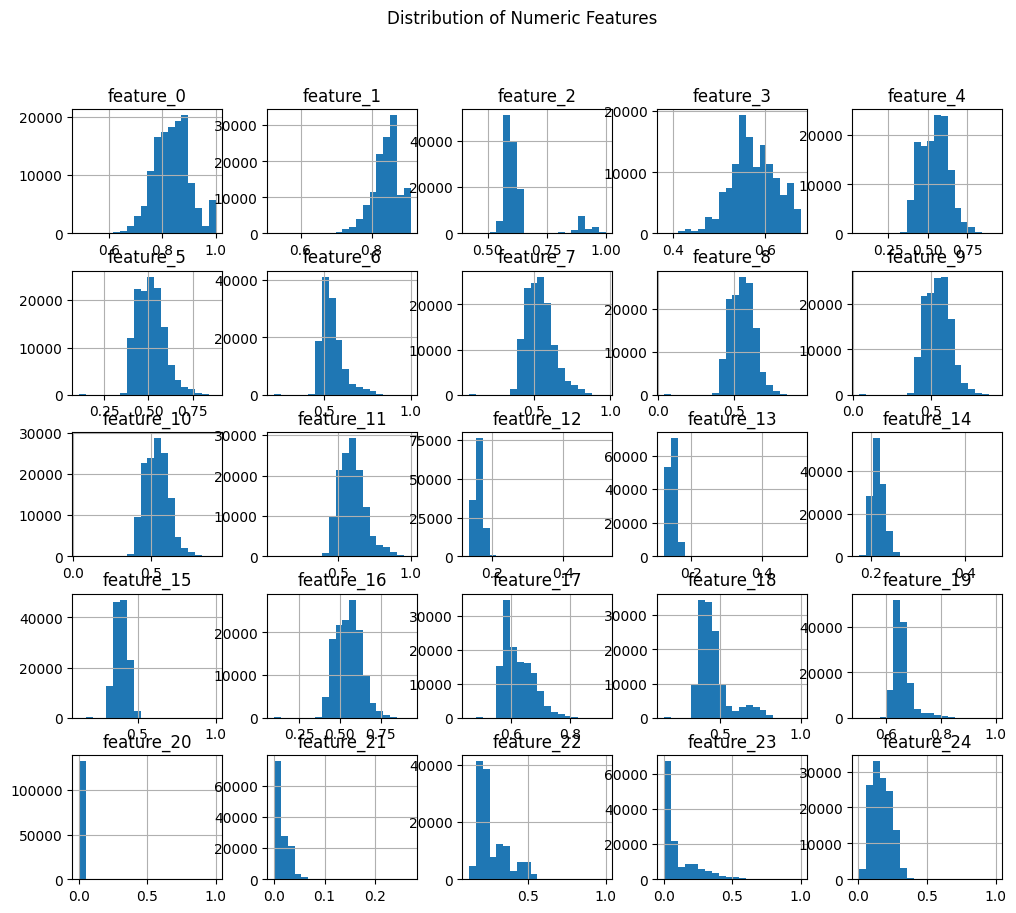

In [ ]:
# Visualize the distribution of numeric features
plt.figure(figsize=(12, 10))
train_data.drop(columns=['timestamp_(min)']).hist(bins=20, figsize=(12, 10))
plt.suptitle('Distribution of Numeric Features')
plt.show()


In [ ]:
import numpy as np

def random_masking(data, p=0.1):
    mask = np.random.choice([0, 1], size=data.shape, p=[p, 1-p])
    masked_data = data * mask
    return masked_data


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_len, num_features, rate=0.1):
        super(TransformerEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_encoding = self.positional_encoding(input_seq_len, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # Adding position encoding.
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class Discriminator(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(Discriminator, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class ContrastiveLearning(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(ContrastiveLearning, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])


# **TASK 2**

In [ ]:
#------------------------------------------------------------------------
train_data = np.genfromtxt('train.csv', delimiter=',', skip_header=1)
test_data = np.genfromtxt('test.csv', delimiter=',', skip_header=1)
test_label = np.genfromtxt('test_label.csv', delimiter=',', skip_header=1)

In [ ]:
# Check the shape of train_data
print("Shape of train_data:", train_data.shape)

num_features = train_data.shape[1]

Shape of train_data: (132481, 26)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the positional_encoding function
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

# Define the Transformer Encoder layer
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_len, num_features, rate=0.1):
        super(TransformerEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_encoding = positional_encoding(input_seq_len, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = layers.Dropout(rate)

    def call(self, x, training):
        seq_len = tf.shape(x)[1]

        print("Shape of x:", x.shape)
        print("Shape of positional encoding:", self.pos_encoding[:, :seq_len, :].shape)

        # Broadcast positional encoding to match the shape of x
        pos_enc_broadcasted = tf.tile(self.pos_encoding[:, :seq_len, :], [tf.shape(x)[0], 1, 1])

        # Adding position encoding.
        x += pos_enc_broadcasted

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)

        return x

# Define the EncoderLayer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Define the Discriminator module
class Discriminator(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(Discriminator, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Define the Contrastive Learning module
class ContrastiveLearning(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(ContrastiveLearning, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

    # Define the full model incorporating all components
    class AnomalyDetectionModel(tf.keras.Model):
        def __init__(self, num_layers, d_model, num_heads, dff, input_seq_len, num_features, rate=0.1):
            super(AnomalyDetectionModel, self).__init__()

            self.transformer_encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, input_seq_len, num_features, rate)
            self.discriminator = Discriminator(d_model, num_heads, dff, rate)
            self.contrastive_learning = ContrastiveLearning(d_model, num_heads, dff, rate)

        def call(self, x, training):
            x_transformer = self.transformer_encoder(x, training)
            x_discriminator = self.discriminator(x_transformer, training)
            x_contrastive = self.contrastive_learning(x_transformer, training)

            return x_transformer, x_discriminator, x_contrastive

        def train_step(self, data):
            x, y = data

            with tf.GradientTape() as tape:
                # Forward pass
                x_transformer, x_discriminator, x_contrastive = self(x, training=True)
                # Compute the loss
                loss = tf.keras.losses.MeanSquaredError(y_true=y, y_pred=x_transformer)

            # Compute gradients
            gradients = tape.gradient(loss, self.trainable_variables)
            # Update weights
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            return {"loss": loss}


# Instantiate the model
anomaly_detection_model = AnomalyDetectionModel(num_layers, d_model, num_heads, dff, input_seq_len, num_features)

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError()

# Compile the model
anomaly_detection_model.compile(optimizer=optimizer, loss=loss_object)
epochs = 10
batch_size = 32  # You can adjust this based on your available memory and dataset size

# Train your model using the fit method
history = anomaly_detection_model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/10
Shape of x: (32, 25)
Shape of positional encoding: (1, 25, 128)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "<ipython-input-57-c3fd3ce7f436>", line 151, in train_step
        x_transformer, x_discriminator, x_contrastive = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileolwxhnj2.py", line 10, in tf__call
        x_transformer = ag__.converted_call(ag__.ld(self).transformer_encoder, (ag__.ld(x), ag__.ld(training)), None, fscope)
    File "/tmp/__autograph_generated_filehdiph8p4.py", line 15, in tf__call
        x += pos_enc_broadcasted

    ValueError: Exception encountered when calling layer 'anomaly_detection_model_8' (type AnomalyDetectionModel).
    
    in user code:
    
        File "<ipython-input-57-c3fd3ce7f436>", line 140, in call  *
            x_transformer = self.transformer_encoder(x, training)
        File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_filehdiph8p4.py", line 15, in tf__call
            x += pos_enc_broadcasted
    
        ValueError: Exception encountered when calling layer 'transformer_encoder_15' (type TransformerEncoder).
        
        in user code:
        
            File "<ipython-input-57-c3fd3ce7f436>", line 46, in call  *
                x += pos_enc_broadcasted
        
            ValueError: Dimensions must be equal, but are 32 and 25 for '{{node anomaly_detection_model_8/transformer_encoder_15/add}} = AddV2[T=DT_FLOAT](anomaly_detection_model_8/Cast, anomaly_detection_model_8/transformer_encoder_15/Tile)' with input shapes: [32,25], [32,25,128].
        
        
        Call arguments received by layer 'transformer_encoder_15' (type TransformerEncoder):
          • x=tf.Tensor(shape=(32, 25), dtype=float32)
          • training=True
    
    
    Call arguments received by layer 'anomaly_detection_model_8' (type AnomalyDetectionModel):
      • x=tf.Tensor(shape=(32, 25), dtype=float32)
      • training=True
